# Exploración de Datos - Bitcoin Forensics 

Este notebook contiene un análisis exploratorio completo del dataset de transacciones Bitcoin de Elliptic, enfocado en la detección de actividades ilícitas.

## Estructura del Análisis:
1. **Configuración y Conexión**
2. **Estadísticas Básicas del Dataset**
3. **Análisis Temporal de Transacciones**
4. **Análisis de Clasificación (Ilícitas vs Lícitas)**
5. **Análisis de Red y Conectividad**
6. **Análisis de Centralidad y Hubs**
7. **Patrones de Flujo de Fondos**
8. **Visualizaciones Avanzadas de la Red**
9. **Análisis de Features (si disponibles)**
10. **Resumen y Conclusiones**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
import altair as alt
from neo4j import GraphDatabase
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")
print("Configuración de visualizaciones lista")

Librerías importadas correctamente
Configuración de visualizaciones lista


In [2]:

URI = "neo4j+ssc://3dddc413.databases.neo4j.io" 
AUTH = ("neo4j", "uT5Hwz7OKdMBuE4mb8WPSz0AmKu0yY57zacumyaifZc")

def run_query(query, params=None):
    
    with GraphDatabase.driver(URI, auth=AUTH) as driver:
        with driver.session() as session:
            result = session.run(query, params or {})
            return [r.data() for r in result]

def query_to_df(query, params=None):
   
    data = run_query(query, params)
    return pd.DataFrame(data)


try:
    test_result = run_query("RETURN 1 as test, datetime() as timestamp")
    print("Conexión exitosa a Neo4j AuraDB")
    print(f"Timestamp del servidor: {test_result[0]['timestamp']}")
except Exception as e:
    print(f" Error de conexión: {e}")
    print(" Verificar credenciales y estado de la instancia")

Conexión exitosa a Neo4j AuraDB
Timestamp del servidor: 2025-11-23T15:46:14.097000000+00:00


## Estadísticas Básicas del Dataset

In [3]:



basic_stats_query = """
MATCH (t:Transaction)
RETURN 
    count(t) as total_transactions,
    count(DISTINCT t.time_step) as unique_timesteps,
    min(toInteger(t.time_step)) as min_timestep,
    max(toInteger(t.time_step)) as max_timestep,
    sum(CASE WHEN t.class = '1' THEN 1 ELSE 0 END) as illicit_count,
    sum(CASE WHEN t.class = '2' THEN 1 ELSE 0 END) as licit_count,
    sum(CASE WHEN t.class = 'unknown' THEN 1 ELSE 0 END) as unknown_count
"""

# Estadísticas de relaciones
relationship_stats_query = """
MATCH ()-[r:TRANSFER]->()
RETURN 
    count(r) as total_transfers,
    count(DISTINCT startNode(r)) as unique_senders,
    count(DISTINCT endNode(r)) as unique_receivers
"""

# Obtener datos
basic_stats = query_to_df(basic_stats_query)
rel_stats = query_to_df(relationship_stats_query)

print(" ESTADÍSTICAS GENERALES DEL DATASET")
print("=" * 50)
print(f" Total de Transacciones: {basic_stats['total_transactions'].iloc[0]:,}")
print(f" Rango Temporal: {basic_stats['min_timestep'].iloc[0]} - {basic_stats['max_timestep'].iloc[0]} ({basic_stats['unique_timesteps'].iloc[0]} time steps)")
print(f" Total de Transferencias: {rel_stats['total_transfers'].iloc[0]:,}")
print(f" Nodos Emisores Únicos: {rel_stats['unique_senders'].iloc[0]:,}")
print(f" Nodos Receptores Únicos: {rel_stats['unique_receivers'].iloc[0]:,}")

print(f"\n DISTRIBUCIÓN POR CLASIFICACIÓN")
print("=" * 50)
print(f" Transacciones Ilícitas: {basic_stats['illicit_count'].iloc[0]:,}")
print(f" Transacciones Lícitas: {basic_stats['licit_count'].iloc[0]:,}")
print(f" Transacciones Desconocidas: {basic_stats['unknown_count'].iloc[0]:,}")

# Calcular porcentajes
total = basic_stats['total_transactions'].iloc[0]
illicit_pct = (basic_stats['illicit_count'].iloc[0] / total) * 100
licit_pct = (basic_stats['licit_count'].iloc[0] / total) * 100
unknown_pct = (basic_stats['unknown_count'].iloc[0] / total) * 100

print(f"\n PORCENTAJES")
print("=" * 50)
print(f" Ilícitas: {illicit_pct:.2f}%")
print(f" Lícitas: {licit_pct:.2f}%")
print(f" Desconocidas: {unknown_pct:.2f}%")


stats_summary = {
    'total_transactions': basic_stats['total_transactions'].iloc[0],
    'total_transfers': rel_stats['total_transfers'].iloc[0],
    'illicit_count': basic_stats['illicit_count'].iloc[0],
    'licit_count': basic_stats['licit_count'].iloc[0],
    'unknown_count': basic_stats['unknown_count'].iloc[0],
    'min_timestep': basic_stats['min_timestep'].iloc[0],
    'max_timestep': basic_stats['max_timestep'].iloc[0],
    'unique_timesteps': basic_stats['unique_timesteps'].iloc[0]
}

 ESTADÍSTICAS GENERALES DEL DATASET
 Total de Transacciones: 180,000
 Rango Temporal: 1 - 44 (44 time steps)
 Total de Transferencias: 207,361
 Nodos Emisores Únicos: 147,370
 Nodos Receptores Únicos: 132,523

 DISTRIBUCIÓN POR CLASIFICACIÓN
 Transacciones Ilícitas: 4,403
 Transacciones Lícitas: 37,171
 Transacciones Desconocidas: 138,426

 PORCENTAJES
 Ilícitas: 2.45%
 Lícitas: 20.65%
 Desconocidas: 76.90%


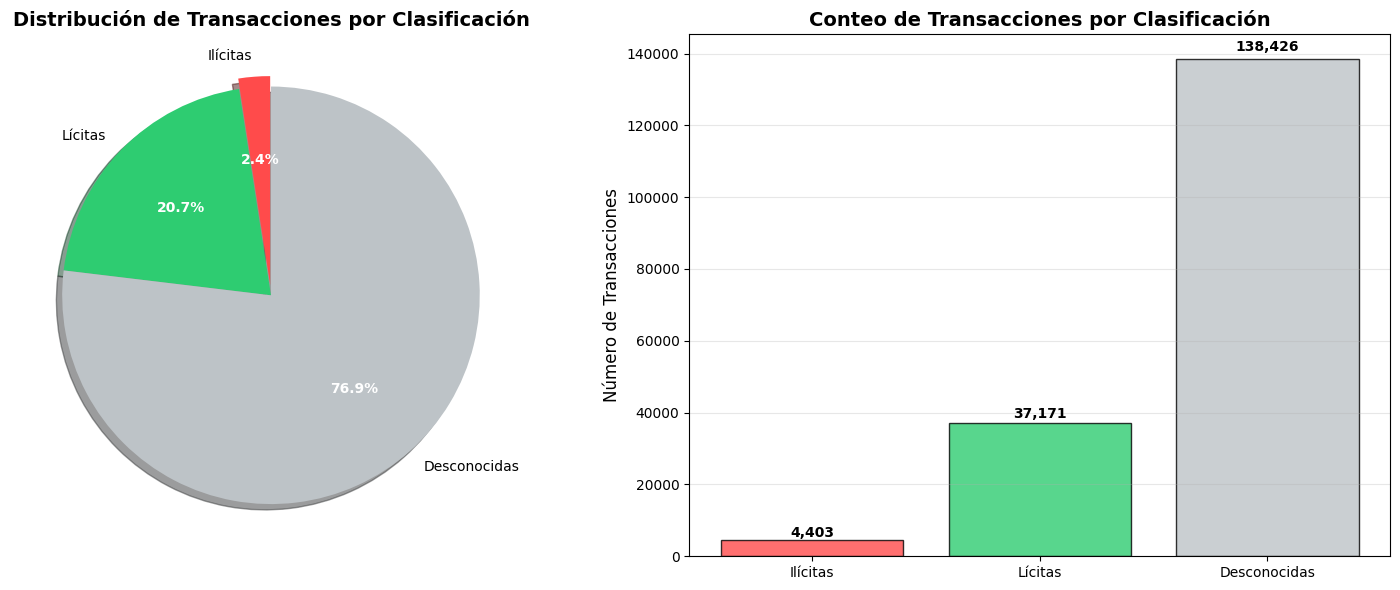

 Observaciones iniciales:
• Las transacciones ilícitas representan 2.4% del total clasificado
• Ratio ilícito/lícito: 1:8.4
• 76.9% de transacciones sin clasificar requieren análisis adicional


In [4]:



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


labels = ['Ilícitas', 'Lícitas', 'Desconocidas']
sizes = [stats_summary['illicit_count'], stats_summary['licit_count'], stats_summary['unknown_count']]
colors = ['#FF4B4B', '#2ECC71', '#BDC3C7']
explode = (0.05, 0, 0)  # Resaltar las ilícitas

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                                   startangle=90, explode=explode, shadow=True)
ax1.set_title('Distribución de Transacciones por Clasificación', fontsize=14, fontweight='bold')


for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Gráfico de barras
categories = ['Ilícitas', 'Lícitas', 'Desconocidas']  
bars = ax2.bar(categories, sizes, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_title('Conteo de Transacciones por Clasificación', fontsize=14, fontweight='bold')
ax2.set_ylabel('Número de Transacciones', fontsize=12)
ax2.grid(axis='y', alpha=0.3)


for bar, size in zip(bars, sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{size:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Observaciones iniciales:")
print(f"• Las transacciones ilícitas representan {illicit_pct:.1f}% del total clasificado")
print(f"• Ratio ilícito/lícito: 1:{licit_pct/illicit_pct:.1f}")
print(f"• {unknown_pct:.1f}% de transacciones sin clasificar requieren análisis adicional")

## Análisis Temporal de Transacciones

In [5]:


# Evolución temporal por clasificación
temporal_query = """
MATCH (t:Transaction) 
WHERE t.class IN ['1', '2']
RETURN 
    toInteger(t.time_step) as timestep, 
    t.class as classification,
    count(t) as transaction_count
ORDER BY timestep ASC
"""

temporal_df = query_to_df(temporal_query)

activity_query = """
MATCH (t:Transaction)
RETURN 
    toInteger(t.time_step) as timestep,
    count(t) as total_transactions,
    sum(CASE WHEN t.class = '1' THEN 1 ELSE 0 END) as illicit_count,
    sum(CASE WHEN t.class = '2' THEN 1 ELSE 0 END) as licit_count,
    sum(CASE WHEN t.class = 'unknown' THEN 1 ELSE 0 END) as unknown_count
ORDER BY timestep
"""

activity_df = query_to_df(activity_query)

print(" ANÁLISIS TEMPORAL COMPLETADO")
print(f" Datos obtenidos para {len(activity_df)} timesteps")
print(f"Rango: {activity_df['timestep'].min()} - {activity_df['timestep'].max()}")


top_activity = activity_df.nlargest(5, 'total_transactions')
print(f"\n TOP 5 TIMESTEPS CON MAYOR ACTIVIDAD:")
for _, row in top_activity.iterrows():
    print(f"   Timestep {row['timestep']}: {row['total_transactions']:,} transacciones")


top_illicit = activity_df.nlargest(5, 'illicit_count')
print(f"\n TOP 5 TIMESTEPS CON MAYOR ACTIVIDAD ILÍCITA:")
for _, row in top_illicit.iterrows():
    print(f"   Timestep {row['timestep']}: {row['illicit_count']:,} transacciones ilícitas")

 ANÁLISIS TEMPORAL COMPLETADO
 Datos obtenidos para 44 timesteps
Rango: 1 - 44

 TOP 5 TIMESTEPS CON MAYOR ACTIVIDAD:
   Timestep 1: 7,880 transacciones
   Timestep 42: 7,140 transacciones
   Timestep 5: 6,803 transacciones
   Timestep 10: 6,727 transacciones
   Timestep 3: 6,621 transacciones

 TOP 5 TIMESTEPS CON MAYOR ACTIVIDAD ILÍCITA:
   Timestep 32: 342 transacciones ilícitas
   Timestep 29: 329 transacciones ilícitas
   Timestep 13: 291 transacciones ilícitas
   Timestep 20: 260 transacciones ilícitas
   Timestep 9: 248 transacciones ilícitas


In [10]:



fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=(
        'Evolución Temporal: Ilícitas vs Lícitas',
        'Actividad Total por Timestep', 
        'Proporción de Transacciones Ilícitas',
        'Distribución de Actividad por Timestep'
    ),
    specs=[[{"secondary_y": False}],
           [{"secondary_y": False}],
           [{"secondary_y": True}],
           [{"type": "histogram"}]]
)

# Gráfico 1: Evolución temporal ilícitas vs lícitas
illicit_data = temporal_df[temporal_df['classification'] == '1']
licit_data = temporal_df[temporal_df['classification'] == '2']

fig.add_trace(
    go.Scatter(x=illicit_data['timestep'], y=illicit_data['transaction_count'],
               mode='lines+markers', name='Ilícitas', line=dict(color='#FF4B4B', width=3)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=licit_data['timestep'], y=licit_data['transaction_count'],
               mode='lines+markers', name='Lícitas', line=dict(color='#2ECC71', width=3)),
    row=1, col=1
)

# Gráfico 2: Actividad total
fig.add_trace(
    go.Scatter(x=activity_df['timestep'], y=activity_df['total_transactions'],
               mode='lines', name='Total', line=dict(color='#3498DB', width=2),
               fill='tonexty'),
    row=2, col=1, 
)

# Gráfico 3: Proporción de ilícitas (con eje secundario)
activity_df['illicit_proportion'] = activity_df['illicit_count'] / (activity_df['illicit_count'] + activity_df['licit_count']) * 100

fig.add_trace(
    go.Bar(x=activity_df['timestep'], y=activity_df['total_transactions'],
           name='Vo1lumen Total', marker_color='lightblue', opacity=0.6),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=activity_df['timestep'], y=activity_df['illicit_proportion'],
               mode='lines+markers', name='% Ilícitas', 
               line=dict(color='red', width=3), yaxis='y2'),
    row=3, col=1, secondary_y=True
)

# Gráfico 4: Histograma de distribución
fig.add_trace(
    go.Histogram(x=activity_df['total_transactions'], nbinsx=20, 
                 name='Distribución', marker_color='purple', opacity=0.7),
    row=4, col=1
)

# Actualizar layout
fig.update_layout(
    height=800,
    title_text=" Análisis Temporal Completo del Dataset Elliptic",
    title_x=0.5,
    showlegend=True
)

# Actualizar ejes
fig.update_xaxes(title_text="Timestep", row=1, col=1)
fig.update_xaxes(title_text="Timestep", row=1, col=2)
fig.update_xaxes(title_text="Timestep", row=2, col=1)
fig.update_xaxes(title_text="Transacciones por Timestep", row=2, col=2)

fig.update_yaxes(title_text="Número de Transacciones", row=1, col=1)
fig.update_yaxes(title_text="Transacciones Totales", row=1, col=2)
fig.update_yaxes(title_text="Volumen", row=2, col=1)
fig.update_yaxes(title_text="% Ilícitas", secondary_y=True, row=2, col=1)
fig.update_yaxes(title_text="Frecuencia", row=2, col=2)

fig.show()

# Estadísticas temporales adicionales
avg_illicit_prop = activity_df['illicit_proportion'].mean()
max_illicit_prop = activity_df['illicit_proportion'].max()
min_illicit_prop = activity_df['illicit_proportion'].min()

print(f"\n ESTADÍSTICAS DE PROPORCIÓN ILÍCITA:")
print(f"   Promedio: {avg_illicit_prop:.2f}%")
print(f"   Máximo: {max_illicit_prop:.2f}%")
print(f"   Mínimo: {min_illicit_prop:.2f}%")


 ESTADÍSTICAS DE PROPORCIÓN ILÍCITA:
   Promedio: 12.11%
   Máximo: 35.97%
   Mínimo: 0.43%


## Análisis de Red y Conectividad

In [12]:


# Distribución de grados de salida (out-degree)
out_degree_query = """
MATCH (t:Transaction)-[r:TRANSFER]->()
WITH t, count(r) as out_degree
RETURN 
    out_degree,
    count(*) as frequency,
    collect(t.class) as classes
ORDER BY out_degree
"""

# Distribución de grados de entrada (in-degree)  
in_degree_query = """
MATCH ()-[r:TRANSFER]->(t:Transaction)
WITH t, count(r) as in_degree
RETURN 
    in_degree,
    count(*) as frequency,
    collect(t.class) as classes
ORDER BY in_degree
"""

# Top nodos por out-degree
top_out_query = """
MATCH (t:Transaction)-[r:TRANSFER]->()
WITH t, count(r) as out_degree
RETURN 
    t.tx_id as tx_id,
    t.class as classification,
    t.time_step as timestep,
    out_degree
ORDER BY out_degree DESC
LIMIT 20
"""

# Top nodos por in-degree
top_in_query = """
MATCH ()-[r:TRANSFER]->(t:Transaction)
WITH t, count(r) as in_degree
RETURN 
    t.tx_id as tx_id,
    t.class as classification,
    t.time_step as timestep,
    in_degree
ORDER BY in_degree DESC
LIMIT 20
"""

# Ejecutar consultas
out_degree_df = query_to_df(out_degree_query)
in_degree_df = query_to_df(in_degree_query)
top_out_df = query_to_df(top_out_query)
top_in_df = query_to_df(top_in_query)

print(" ANÁLISIS DE CENTRALIDAD COMPLETADO")
print(f" Distribuciones de grado calculadas")
print(f" Top 20 nodos por centralidad identificados")

# Estadísticas básicas de grados
total_out_edges = (out_degree_df['out_degree'] * out_degree_df['frequency']).sum()
total_in_edges = (in_degree_df['in_degree'] * in_degree_df['frequency']).sum()
avg_out_degree = total_out_edges / out_degree_df['frequency'].sum()
avg_in_degree = total_in_edges / in_degree_df['frequency'].sum()

print(f"\n ESTADÍSTICAS DE GRADOS:")
print(f" Promedio out-degree: {avg_out_degree:.2f}")
print(f" Promedio in-degree: {avg_in_degree:.2f}")
print(f" Max out-degree: {out_degree_df['out_degree'].max()}")
print(f" Max in-degree: {in_degree_df['in_degree'].max()}")

# Análisis de los top nodos
illicit_out_hubs = top_out_df[top_out_df['classification'] == '1']
licit_out_hubs = top_out_df[top_out_df['classification'] == '2']

print(f"\n TOP OUT-DEGREE HUBS:")
print(f" Ilícitos en top 20: {len(illicit_out_hubs)}")
print(f" Lícitos en top 20: {len(licit_out_hubs)}")

if len(illicit_out_hubs) > 0:
    print(f" Mayor out-degree ilícito: {illicit_out_hubs['out_degree'].max()}")
if len(licit_out_hubs) > 0:
    print(f" Mayor out-degree lícito: {licit_out_hubs['out_degree'].max()}")

 ANÁLISIS DE CENTRALIDAD COMPLETADO
 Distribuciones de grado calculadas
 Top 20 nodos por centralidad identificados

 ESTADÍSTICAS DE GRADOS:
 Promedio out-degree: 1.41
 Promedio in-degree: 1.56
 Max out-degree: 472
 Max in-degree: 284

 TOP OUT-DEGREE HUBS:
 Ilícitos en top 20: 0
 Lícitos en top 20: 8
 Mayor out-degree lícito: 472


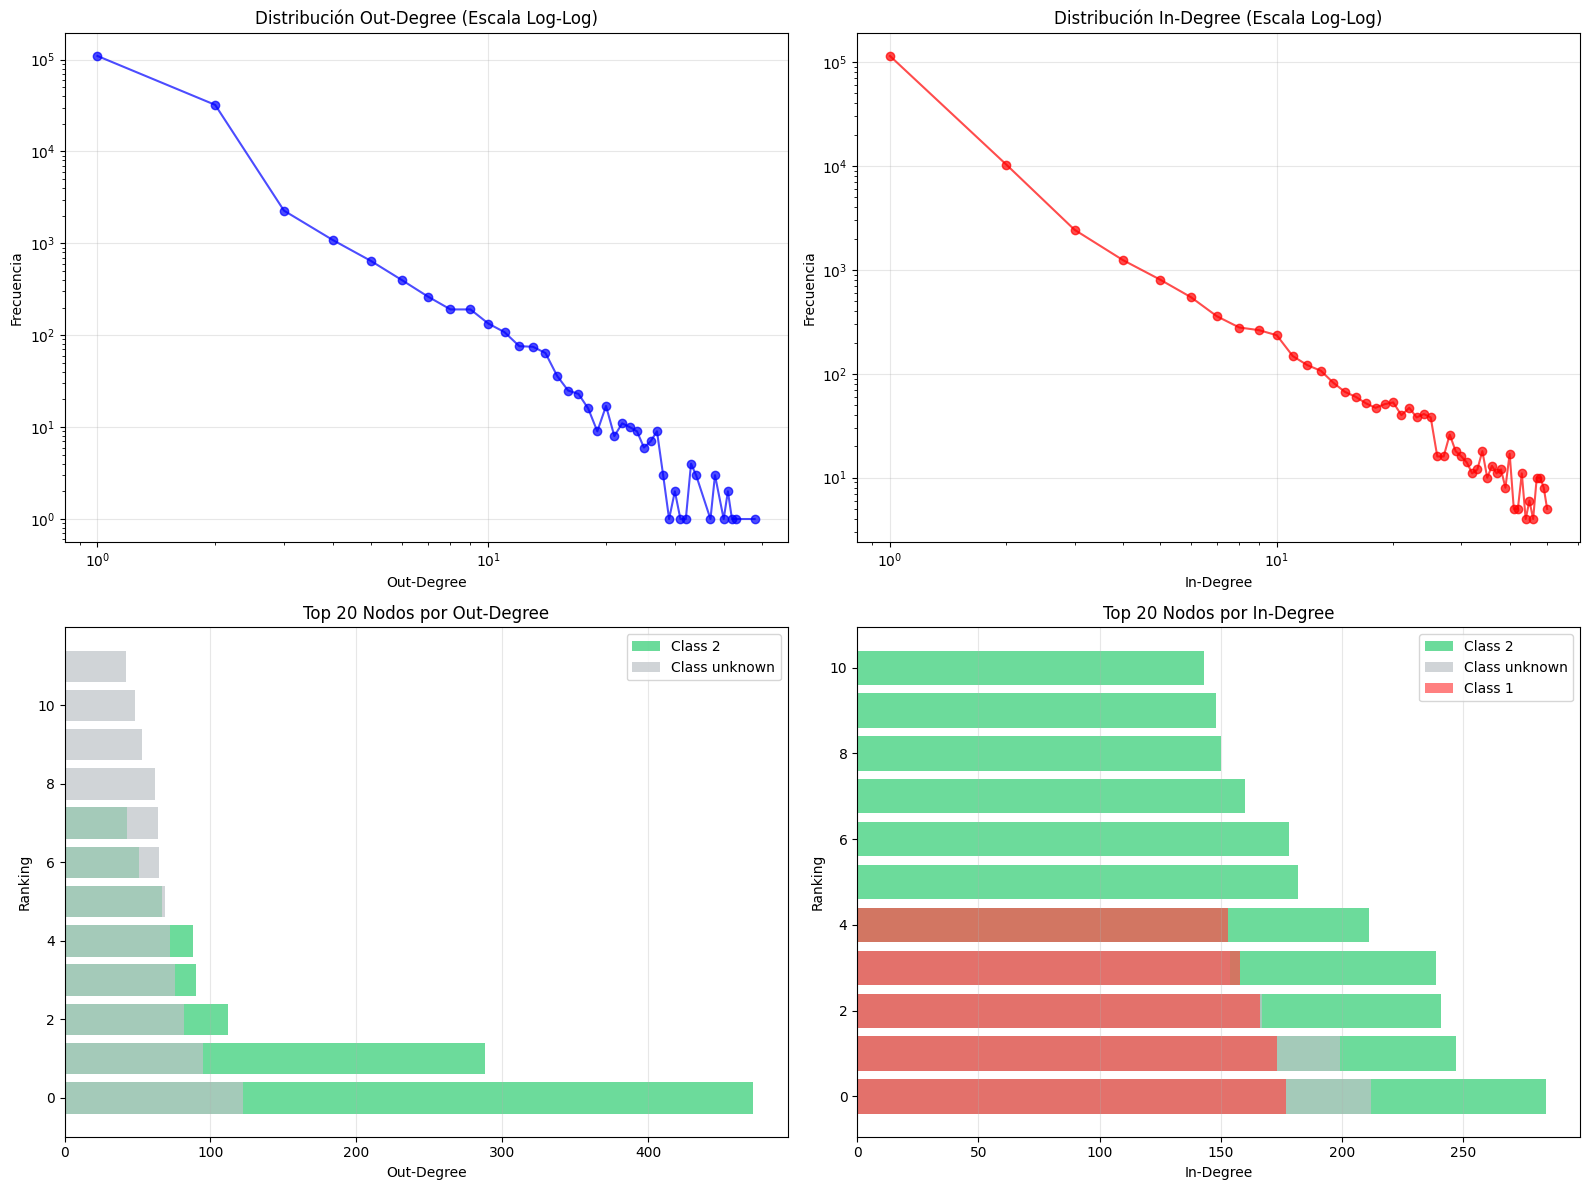

 TOP 10 OUT-DEGREE HUBS:
  tx_id classification  timestep
2984918              2        22
  89273              2         1
 102570        unknown        36
   3181              2        34
1891081        unknown        27
 565334              2        10
 488266              2        25
 793584        unknown        43
4600600        unknown        40
3185686        unknown        36

 TOP 10 IN-DEGREE HUBS:
    tx_id classification  timestep
 43388675              2        10
 68705820              2        10
 30699343              2        37
 96576418              2         7
225859042        unknown         5
279187194              2         4
234890810        unknown        11
 43397277              2        10
 68706499              2        10
 30179316              1        37


In [13]:


# Preparar datos para visualización (limitando para mejor legibilidad)
out_degree_viz = out_degree_df[out_degree_df['out_degree'] <= 50].copy()  # Limitar para visualización
in_degree_viz = in_degree_df[in_degree_df['in_degree'] <= 50].copy()

# Crear visualización de distribuciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Out-degree distribution (escala log)
ax1.loglog(out_degree_viz['out_degree'], out_degree_viz['frequency'], 'bo-', alpha=0.7)
ax1.set_xlabel('Out-Degree')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución Out-Degree (Escala Log-Log)')
ax1.grid(True, alpha=0.3)

# In-degree distribution (escala log)
ax2.loglog(in_degree_viz['in_degree'], in_degree_viz['frequency'], 'ro-', alpha=0.7)
ax2.set_xlabel('In-Degree')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución In-Degree (Escala Log-Log)')
ax2.grid(True, alpha=0.3)

# Top out-degree nodes por clasificación
classification_colors = {'1': '#FF4B4B', '2': '#2ECC71', 'unknown': '#BDC3C7'}
for class_type in top_out_df['classification'].unique():
    class_data = top_out_df[top_out_df['classification'] == class_type]
    ax3.barh(range(len(class_data)), class_data['out_degree'], 
             color=classification_colors.get(class_type, '#BDC3C7'), 
             alpha=0.7, label=f'Class {class_type}')

ax3.set_xlabel('Out-Degree')
ax3.set_ylabel('Ranking')
ax3.set_title('Top 20 Nodos por Out-Degree')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Top in-degree nodes por clasificación  
for class_type in top_in_df['classification'].unique():
    class_data = top_in_df[top_in_df['classification'] == class_type]
    ax4.barh(range(len(class_data)), class_data['in_degree'], 
             color=classification_colors.get(class_type, '#BDC3C7'), 
             alpha=0.7, label=f'Class {class_type}')

ax4.set_xlabel('In-Degree')
ax4.set_ylabel('Ranking')
ax4.set_title('Top 20 Nodos por In-Degree')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Crear tabla de top hubs
print(" TOP 10 OUT-DEGREE HUBS:")
print("=" * 80)
display_cols = ['tx_id', 'classification', 'timestep']
print(top_out_df[display_cols].head(10).to_string(index=False))

print(f"\n TOP 10 IN-DEGREE HUBS:")
print("=" * 80)
print(top_in_df[display_cols].head(10).to_string(index=False))

## 💸 Análisis de Patrones de Flujo de Fondos

In [14]:


# Patrones de flujo desde nodos ilícitos
illicit_flow_query = """
MATCH (source:Transaction {class: '1'})-[r:TRANSFER]->(target:Transaction)
RETURN 
    target.class as target_class,
    count(r) as transfer_count,
    count(DISTINCT source.tx_id) as unique_illicit_sources,
    count(DISTINCT target.tx_id) as unique_targets
ORDER BY transfer_count DESC
"""


flow_to_illicit_query = """
MATCH (source:Transaction)-[r:TRANSFER]->(target:Transaction {class: '1'})
RETURN 
    source.class as source_class,
    count(r) as transfer_count,
    count(DISTINCT source.tx_id) as unique_sources,
    count(DISTINCT target.tx_id) as unique_illicit_targets
ORDER BY transfer_count DESC
"""

# Análisis de mixing patterns (homofilia vs heterofilia)
mixing_query = """
MATCH (a:Transaction)-[r:TRANSFER]->(b:Transaction)
WHERE a.class IN ['1', '2'] AND b.class IN ['1', '2']
RETURN 
    a.class as source_class,
    b.class as target_class,
    count(r) as edge_count
ORDER BY source_class, target_class
"""


illicit_flow_df = query_to_df(illicit_flow_query)
flow_to_illicit_df = query_to_df(flow_to_illicit_query)
mixing_df = query_to_df(mixing_query)

print(" ANÁLISIS DE FLUJOS COMPLETADO")
print("=" * 50)

print(f"\n FLUJOS DESDE NODOS ILÍCITOS:")
for _, row in illicit_flow_df.iterrows():
    target_type = "Ilícitos" if row['target_class'] == '1' else ("Lícitos" if row['target_class'] == '2' else "Desconocidos")
    print(f" → {target_type}: {row['transfer_count']:,} transferencias")
    print(f"  Desde {row['unique_illicit_sources']:,} fuentes ilícitas → {row['unique_targets']:,} destinos")

print(f"\n FLUJOS HACIA NODOS ILÍCITOS:")
for _, row in flow_to_illicit_df.iterrows():
    source_type = "Ilícitos" if row['source_class'] == '1' else ("Lícitos" if row['source_class'] == '2' else "Desconocidos")
    print(f" {source_type} → Ilícitos: {row['transfer_count']:,} transferencias")
    print(f"  Desde {row['unique_sources']:,} fuentes → {row['unique_illicit_targets']:,} destinos ilícitos")

print(f"\n MATRIZ DE MIXING (HOMOFILIA/HETEROFILIA):")
print("=" * 50)
for _, row in mixing_df.iterrows():
    source_label = "Ilícito" if row['source_class'] == '1' else "Lícito"
    target_label = "Ilícito" if row['target_class'] == '1' else "Lícito"
    pattern_type = "HOMOFILIA" if row['source_class'] == row['target_class'] else "HETEROFILIA"
    print(f"   {source_label} → {target_label}: {row['edge_count']:,} ({pattern_type})")


total_edges = mixing_df['edge_count'].sum()
homophilic_edges = mixing_df[mixing_df['source_class'] == mixing_df['target_class']]['edge_count'].sum()
homophily_coefficient = homophilic_edges / total_edges if total_edges > 0 else 0

print(f"\nCOEFICIENTE DE HOMOFILIA: {homophily_coefficient:.3f}")
print(f" • {homophily_coefficient * 100:.1f}% de las conexiones son homofílicas")
print(f" • {(1 - homophily_coefficient) * 100:.1f}% de las conexiones son heterofílicas")

 ANÁLISIS DE FLUJOS COMPLETADO

 FLUJOS DESDE NODOS ILÍCITOS:
 → Desconocidos: 1,416 transferencias
  Desde 1,377 fuentes ilícitas → 353 destinos
 → Ilícitos: 977 transferencias
  Desde 970 fuentes ilícitas → 896 destinos
 → Lícitos: 828 transferencias
  Desde 828 fuentes ilícitas → 307 destinos

 FLUJOS HACIA NODOS ILÍCITOS:
 Desconocidos → Ilícitos: 3,844 transferencias
  Desde 3,528 fuentes → 2,062 destinos ilícitos
 Ilícitos → Ilícitos: 977 transferencias
  Desde 970 fuentes → 896 destinos ilícitos
 Lícitos → Ilícitos: 761 transferencias
  Desde 689 fuentes → 459 destinos ilícitos

 MATRIZ DE MIXING (HOMOFILIA/HETEROFILIA):
   Ilícito → Ilícito: 977 (HOMOFILIA)
   Ilícito → Lícito: 828 (HETEROFILIA)
   Lícito → Ilícito: 761 (HETEROFILIA)
   Lícito → Lícito: 29,459 (HOMOFILIA)

COEFICIENTE DE HOMOFILIA: 0.950
 • 95.0% de las conexiones son homofílicas
 • 5.0% de las conexiones son heterofílicas


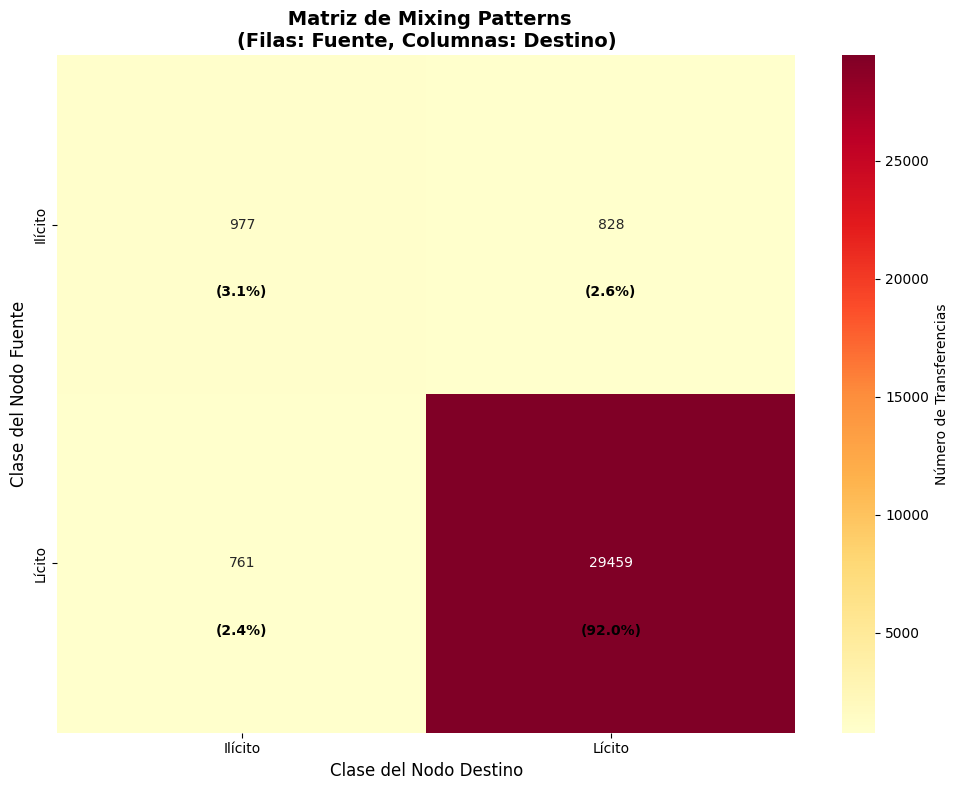

 INTERPRETACIÓN DE MIXING PATTERNS:
• Diagonal principal (homofilia): conexiones dentro del mismo tipo
• Diagonal secundaria (heterofilia): conexiones entre tipos diferentes
• Un coeficiente de homofilia alto indica segregación en la red
• Un coeficiente bajo indica mayor mezcla entre tipos de nodos


In [15]:



fig = go.Figure()


node_labels = ['Ilícito (Fuente)', 'Lícito (Fuente)', 'Desconocido (Fuente)', 
               'Ilícito (Destino)', 'Lícito (Destino)', 'Desconocido (Destino)']
node_colors = ['#FF4B4B', '#2ECC71', '#BDC3C7', '#FF6B6B', '#52C785', '#D5DBDB']

# Crear matriz de flujos completa
flow_matrix_query = """
MATCH (source:Transaction)-[r:TRANSFER]->(target:Transaction)
RETURN 
    COALESCE(source.class, 'unknown') as source_class,
    COALESCE(target.class, 'unknown') as target_class,
    count(r) as flow_count
"""

flow_matrix_df = query_to_df(flow_matrix_query)

class_to_source_idx = {'1': 0, '2': 1, 'unknown': 2}
class_to_target_idx = {'1': 3, '2': 4, 'unknown': 5}

sources = []
targets = []
values = []

for _, row in flow_matrix_df.iterrows():
    source_idx = class_to_source_idx[row['source_class']]
    target_idx = class_to_target_idx[row['target_class']]
    sources.append(source_idx)
    targets.append(target_idx)
    values.append(row['flow_count'])


fig.add_trace(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=['rgba(255,75,75,0.3)' if s == 0 else 'rgba(46,204,113,0.3)' if s == 1 else 'rgba(189,195,199,0.3)' 
               for s in sources]
    )
))

fig.update_layout(
    title_text=" Diagrama de Flujo de Fondos (Sankey)",
    font_size=12,
    height=600
)

fig.show()

# Crear matriz de confusión visual para mixing patterns
mixing_pivot = mixing_df.pivot(index='source_class', columns='target_class', values='edge_count').fillna(0)

plt.figure(figsize=(10, 8))

# Crear heatmap
sns.heatmap(mixing_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=['Ilícito', 'Lícito'], 
            yticklabels=['Ilícito', 'Lícito'],
            cbar_kws={'label': 'Número de Transferencias'})

plt.title(' Matriz de Mixing Patterns\n(Filas: Fuente, Columnas: Destino)', fontsize=14, fontweight='bold')
plt.xlabel('Clase del Nodo Destino', fontsize=12)
plt.ylabel('Clase del Nodo Fuente', fontsize=12)

# Añadir porcentajes
total = mixing_pivot.values.sum()
for i in range(len(mixing_pivot.index)):
    for j in range(len(mixing_pivot.columns)):
        value = mixing_pivot.iloc[i, j]
        percentage = (value / total) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f" INTERPRETACIÓN DE MIXING PATTERNS:")
print(f"• Diagonal principal (homofilia): conexiones dentro del mismo tipo")
print(f"• Diagonal secundaria (heterofilia): conexiones entre tipos diferentes")
print(f"• Un coeficiente de homofilia alto indica segregación en la red")
print(f"• Un coeficiente bajo indica mayor mezcla entre tipos de nodos")

## Visualización de la Red

In [22]:
network_query = """
MATCH (a:Transaction)-[r:TRANSFER]->(b:Transaction)
WHERE (a.class = '1' OR b.class = '1') 
    AND toInteger(a.time_step) >= 10 AND toInteger(a.time_step) <= 15
RETURN 
    a.tx_id as source,
    b.tx_id as target,
    a.class as source_class,
    b.class as target_class,
    a.time_step as source_timestep,
    b.time_step as target_timestep
LIMIT 100
"""

network_df = query_to_df(network_query)

if len(network_df) > 0:
    print(f" CREANDO VISUALIZACIÓN DE RED")
    print(f" Nodos: {len(pd.concat([network_df[['source', 'source_class']], network_df[['target', 'target_class']].rename(columns={'target': 'source', 'target_class': 'source_class'})]).drop_duplicates())}")
    print(f"🔗 Aristas: {len(network_df)}")

    # Crear grafo con NetworkX
    G = nx.from_pandas_edgelist(network_df, source='source', target='target', create_using=nx.DiGraph())

    # Obtener layout
    pos = nx.spring_layout(G, seed=42, k=1, iterations=50)

    # Preparar trazas de aristas
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        name='Transferencias'
    )

    # Preparar datos de nodos
    node_info = {}
    for _, row in network_df.iterrows():
        node_info[row['source']] = {
            'class': row['source_class'],
            'timestep': row['source_timestep']
        }
        node_info[row['target']] = {
            'class': row['target_class'],
            'timestep': row['target_timestep']
        }

    # Preparar trazas de nodos
    node_x = []
    node_y = []
    node_text = []
    node_color = []
    node_size = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Información del nodo
        node_class = node_info.get(node, {}).get('class', 'unknown')
        node_timestep = node_info.get(node, {}).get('timestep', 'N/A')
        degree = G.degree(node)
        
        # Color según clasificación
        if node_class == '1':
            color = '#FF4B4B'
            class_name = 'Ilícito'
        elif node_class == '2':
            color = '#2ECC71'
            class_name = 'Lícito'
        else:
            color = '#BDC3C7'
            class_name = 'Desconocido'
        
        node_color.append(color)
        node_size.append(max(8, min(20, degree * 2)))  # Tamaño basado en grado
        
        # Texto hover
        node_text.append(f"ID: {node}<br>"
                        f"Clase: {class_name}<br>"
                        f"Timestep: {node_timestep}<br>"
                        f"Grado: {degree}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            color=node_color,
            size=node_size,
            line_width=1,
            line_color='black'
        ),
        name='Transacciones'
    )

    # Crear figura
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=dict(
                            text='Red de Transacciones Bitcoin (Subgrafo Ilícito)',
                            font=dict(size=16)
                        ),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=60),
                        annotations=[ dict(
                            text="🔴 Ilícito | 🟢 Lícito | ⚪ Desconocido",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            xanchor='left', yanchor='bottom',
                            font=dict(size=12)
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        plot_bgcolor='white'))

    fig.show()

    # Análisis básico del subgrafo
    print(f"\n MÉTRICAS DEL SUBGRAFO:")
    print(f"   Nodos: {G.number_of_nodes()}")
    print(f"   Aristas: {G.number_of_edges()}")
    print(f"   Densidad: {nx.density(G):.4f}")
    print(f"   Componentes débilmente conectados: {nx.number_weakly_connected_components(G)}")
    
    if G.number_of_nodes() > 1:
        # Calcular centralidades para los nodos más importantes
        degree_centrality = nx.degree_centrality(G)
        top_central_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print(f"\n TOP 5 NODOS POR CENTRALIDAD DE GRADO:")
        for node, centrality in top_central_nodes:
            node_class = node_info.get(node, {}).get('class', 'unknown')
            class_name = 'Ilícito' if node_class == '1' else ('Lícito' if node_class == '2' else 'Desconocido')
            print(f"   {node} ({class_name}): {centrality:.3f}")

else:
    print(" No se encontraron datos suficientes para la visualización de red")
    print("   Intenta ajustar los filtros de timestep o eliminar algunas restricciones")

 CREANDO VISUALIZACIÓN DE RED
 Nodos: 150
🔗 Aristas: 100



 MÉTRICAS DEL SUBGRAFO:
   Nodos: 150
   Aristas: 100
   Densidad: 0.0045
   Componentes débilmente conectados: 50

 TOP 5 NODOS POR CENTRALIDAD DE GRADO:
   234559571 (Desconocido): 0.040
   234711161 (Lícito): 0.034
   234582045 (Lícito): 0.027
   42627141 (Ilícito): 0.020
   12379727 (Lícito): 0.020
